In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.3 MB/s 
     |████████████████████████████████| 182 kB 80.8 MB/s 
     |████████████████████████████████| 7.6 MB 53.7 MB/s 


In [ ]:
!pip freeze | grep transformers

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 54.5 MB/s 
     |████████████████████████████████| 132 kB 69.5 MB/s 
     |████████████████████████████████| 127 kB 70.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, set_seed
from sklearn.metrics import classification_report
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=12)

In [ ]:
LR = 2e-5
EPOCHS = 200
BATCH_SIZE = 16
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest" 
MAX_TRAINING_EXAMPLES = -1  

In [ ]:
# set transformers seed
seed = 223
set_seed(seed)

In [ ]:
dftrain = pd.read_csv("train.csv")

In [ ]:
dftrain['label'].value_counts()

1    1675
0     425
Name: label, dtype: int64

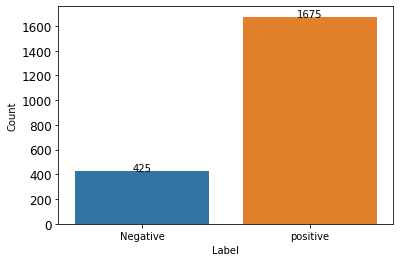

In [ ]:
fig, ax1 = plt.subplots(1,1)
g = sns.countplot(x=dftrain['label'],ax=ax1)

 
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.3,
                s = height,
                ha = 'center',
                fontsize=10)
    
 

plt.xlabel('Label', fontsize = 10 )
plt.ylabel('Count', fontsize = 10 )
g.set_xticklabels(['Negative', 'positive'], fontsize = 10)
plt.show()

In [ ]:
from datasets import load_dataset
data_files = {"train": "train.csv",   "val" : "val.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files, encoding='latin1')
dataset  

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0913db3c28269bb9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'ID', 'likeCount', 'replyCount', 'retweetCount', 'Tweet', 'label'],
        num_rows: 2100
    })
    val: Dataset({
        features: ['Unnamed: 0', 'ID', 'likeCount', 'replyCount', 'retweetCount', 'Tweet', 'label'],
        num_rows: 450
    })
    test: Dataset({
        features: ['Unnamed: 0', 'ID', 'likeCount', 'replyCount', 'retweetCount', 'Tweet', 'label'],
        num_rows: 450
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

dataset = dataset.map(lambda e: tokenizer(e['Tweet'], truncation=True), batched=True)

 
if MAX_TRAINING_EXAMPLES == -1: MAX_TRAINING_EXAMPLES = dataset['train'].shape[0]
 
train_dataset = dataset['train'].select(range(MAX_TRAINING_EXAMPLES))
val_dataset = dataset['val']
test_dataset = dataset['test']

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
num_labels = len(set(train_dataset['labels'])) if 'labels' in train_dataset.features.keys() else len(set(train_dataset['label']))
model = AutoModelForSequenceClassification.from_pretrained(MODEL,   ignore_mismatched_sizes=True, num_labels=num_labels)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

In [ ]:
# Log in to your Hugging Face account 
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
repo_name = "cric-tweets-sentiment-analysis"
training_args = TrainingArguments(
    output_dir=repo_name,                    
    num_train_epochs=EPOCHS,                   
    per_device_train_batch_size=BATCH_SIZE,   
    per_device_eval_batch_size=BATCH_SIZE,     
    warmup_steps=100,                           
    weight_decay=0.01,                         
    logging_dir='./logs', 
    logging_steps=160,                          
    evaluation_strategy='steps',                
    eval_steps=160,                             
    load_best_model_at_end=True,               
    save_steps=160, 
    seed=seed ,                                
    push_to_hub=True        
     

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,                               
    tokenizer=tokenizer,                       
    args=training_args,                        
    train_dataset=train_dataset,               
    eval_dataset=val_dataset, 
    callbacks = [EarlyStoppingCallback(3)], # early stopping which stops the training after 3 evaluation calls with no improvement of performance of at least 0.001
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/sppm/cric-tweets-sentiment-analysis into local empty directory.
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet. If retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True

Step,Training Loss,Validation Loss
160,0.291600,0.281087
320,0.161700,0.343814
480,0.094900,0.348607
640,0.051800,0.395176


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet. If retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 450
  Batch size = 16
Saving model checkpoint to cric-tweets-sentiment-analysis/checkpoint-160
Configuration saved in cric-tweets-sentiment-analysis/checkpoint-160/config.json
Model weights saved in cric-tweets-sentiment-analysis/checkpoint-160/pytorch_model.bin
tokenizer config file saved in cric-tweets-sentiment-analysis/checkpoint-160/tokenizer_config.json
Special tokens file saved in cric-tweets-sentiment-analysis/checkpoint-160/special_tokens_map.json
tokenizer config file saved in cric-tweets-sentiment-analysis/tokenizer_config.json
Special tokens file saved in cric-t

TrainOutput(global_step=640, training_loss=0.15001475661993027, metrics={'train_runtime': 244.8177, 'train_samples_per_second': 1715.563, 'train_steps_per_second': 107.835, 'total_flos': 516974168235120.0, 'train_loss': 0.15001475661993027, 'epoch': 4.85})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet. If retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 450
  Batch size = 16


{'eval_loss': 0.28108692169189453,
 'eval_runtime': 2.2763,
 'eval_samples_per_second': 197.687,
 'eval_steps_per_second': 12.74,
 'epoch': 4.85}

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
# training set 
train_preds_raw, train_labels , _ = trainer.predict(dataset['train'])
train_preds = np.argmax(train_preds_raw, axis=-1)
print(classification_report(train_labels, train_preds, digits=3))
print('ROC AUC = ',str(round(roc_auc_score(train_labels, train_preds)*100,1)), '%')
print('Precision = ',str(round(precision_score(train_labels, train_preds)*100,1)), '%')
print('Recall = ',str(round(recall_score(train_labels, train_preds)*100,1)), '%')
print('Accuracy = ',str(round(accuracy_score(train_labels, train_preds)*100,1)), '%')
print('F1-Score = ',str(round(f1_score(train_labels, train_preds)*100,1)), '%')
confusion_matrix(train_labels, train_preds)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet. If retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2100
  Batch size = 16


              precision    recall  f1-score   support

           0      0.959     0.831     0.890       425
           1      0.958     0.991     0.974      1675

    accuracy                          0.959      2100
   macro avg      0.959     0.911     0.932      2100
weighted avg      0.959     0.959     0.957      2100

ROC AUC =  91.1 %
Precision =  95.8 %
Recall =  99.1 %
Accuracy =  95.9 %
F1-Score =  97.4 %


array([[ 353,   72],
       [  15, 1660]])

In [ ]:
# val set
val_preds_raw, val_labels , _ = trainer.predict(dataset['val'])
val_preds = np.argmax(val_preds_raw, axis=-1)
print(classification_report(val_labels, val_preds, digits=3))
print('ROC AUC = ',str(round(roc_auc_score(val_labels, val_preds)*100,1)), '%')
print('Precision = ',str(round(precision_score(val_labels, val_preds)*100,1)), '%')
print('Recall = ',str(round(recall_score(val_labels, val_preds)*100,1)), '%')
print('Accuracy = ',str(round(accuracy_score(val_labels, val_preds)*100,1)), '%')
print('F1-Score = ',str(round(f1_score(val_labels, val_preds)*100,1)), '%')
confusion_matrix(val_labels, val_preds)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet. If retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 16


              precision    recall  f1-score   support

           0      0.886     0.737     0.805        95
           1      0.933     0.975     0.953       355

    accuracy                          0.924       450
   macro avg      0.909     0.856     0.879       450
weighted avg      0.923     0.924     0.922       450

ROC AUC =  85.6 %
Precision =  93.3 %
Recall =  97.5 %
Accuracy =  92.4 %
F1-Score =  95.3 %


array([[ 70,  25],
       [  9, 346]])

In [ ]:
# test set
test_preds_raw, test_labels , _ = trainer.predict(dataset['test'])
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))
print('ROC AUC = ',str(round(roc_auc_score(test_labels, test_preds)*100,1)), '%')
print('Precision = ',str(round(precision_score(test_labels, test_preds)*100,1)), '%')
print('Recall = ',str(round(recall_score(test_labels, test_preds)*100,1)), '%')
print('Accuracy = ',str(round(accuracy_score(test_labels, test_preds)*100,1)), '%')
print('F1-Score = ',str(round(f1_score(test_labels, test_preds)*100,1)), '%')
confusion_matrix(test_labels, test_preds)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet. If retweetCount, Unnamed: 0, replyCount, ID, likeCount, Tweet are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 16


              precision    recall  f1-score   support

           0      0.829     0.716     0.768        81
           1      0.939     0.967     0.953       369

    accuracy                          0.922       450
   macro avg      0.884     0.842     0.861       450
weighted avg      0.920     0.922     0.920       450

ROC AUC =  84.2 %
Precision =  93.9 %
Recall =  96.7 %
Accuracy =  92.2 %
F1-Score =  95.3 %


array([[ 58,  23],
       [ 12, 357]])

In [ ]:
# Upload the model to the Hub
trainer.push_to_hub()

Saving model checkpoint to cric-tweets-sentiment-analysis
Configuration saved in cric-tweets-sentiment-analysis/config.json
Model weights saved in cric-tweets-sentiment-analysis/pytorch_model.bin
tokenizer config file saved in cric-tweets-sentiment-analysis/tokenizer_config.json
Special tokens file saved in cric-tweets-sentiment-analysis/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/476M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/sppm/cric-tweets-sentiment-analysis
   f1fbc50..93e09d4  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sppm/cric-tweets-sentiment-analysis
   f1fbc50..93e09d4  main -> main



In [ ]:
# Run inferences with your new model using Pipeline
from transformers import pipeline

sentiment_model = pipeline(model="sppm/cric-tweets-sentiment-analysis")

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
list(sentiment_model('Come on India')[0].values())[0]

'LABEL_1'